# Crocodile Dataset

## Initial Data Load & Exploration

In [5]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('crocodile_dataset.csv')
#df.head()
#df.shape
#df.info()
#df.nunique()
#df.describe()
#df.isnull().sum().sort_values(ascending=False)
#df.dtypes

### Data Cleaning

In [6]:
df.columns
df["Date of Observation"] = pd.to_datetime(
    df["Date of Observation"], 
    format="%d-%m-%Y",  # day-month-year
    errors="coerce"
)


### Feature Analysis

In [7]:
import matplotlib.pyplot as plt

print(df["Observed Length (m)"].describe())
#df[df["Observed Length (m)"] < 0.5] #min value = 0.14m, wanted to check if it was realistic. it is because it includes hatchlings.
print(df["Observed Weight (kg)"].describe())

#Histogram
'''
df["Observed Weight (kg)"].hist(bins=30)
plt.xlabel("Length (kg)")
plt.ylabel("Count")
plt.title("Observed Weight Distribution")
plt.show()'''

count    1000.000000
mean        2.415110
std         1.097542
min         0.140000
25%         1.637500
50%         2.430000
75%         3.010000
max         6.120000
Name: Observed Length (m), dtype: float64
count    1000.000000
mean      155.771900
std       175.186788
min         4.400000
25%        53.225000
50%       100.600000
75%       168.875000
max      1139.700000
Name: Observed Weight (kg), dtype: float64


'\ndf["Observed Weight (kg)"].hist(bins=30)\nplt.xlabel("Length (kg)")\nplt.ylabel("Count")\nplt.title("Observed Weight Distribution")\nplt.show()'

### Feature Engineering

#### Extraction of Date Features

In [8]:
df["Date of Observation"] = pd.to_datetime(df["Date of Observation"], errors="coerce")
df["Year"] = df["Date of Observation"].dt.year
df["Month"] = df["Date of Observation"].dt.month
df["Season"] = df["Month"] % 12 // 3 + 1 # 1=winter, 2=spring, 3=summer, 4=fall
df.drop("Date of Observation", axis=1, inplace = True)
numeric_cols = ["Observed Length (m)", "Observed Weight (kg)", "Year", "Month", "Season"]
categorical_cols = ["Genus", "Sex", "Country/Region", "Habitat Type", "Conservation Status"]

#### Age Mapping

In [9]:
age_mapping = {"Hatchling": 0, "Juvenile": 1, "Subadult": 2, "Adult": 3, "Unknown": 4}
['Adult', 'Juvenile', 'Subadult', 'Hatchling']
df["Age Class"] = df["Age Class"].map(age_mapping)
numeric_cols.append("Age Class")

In [10]:
#df.head()

## Categorical Encoding

I use One-Hot encoding to convert the casteogrical fewatures into numeric features.

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),  # one-hot encode categorical
        ("num", "passthrough", numeric_cols)  # keep numeric as-is
    ]
)
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])


#### Train Test Split

In [12]:
from sklearn.model_selection import train_test_split

X = df.drop("Common Name", axis=1)  # features
y = df["Common Name"]               # target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.columns)


Index(['Observation ID', 'Scientific Name', 'Family', 'Genus',
       'Observed Length (m)', 'Observed Weight (kg)', 'Age Class', 'Sex',
       'Country/Region', 'Habitat Type', 'Conservation Status',
       'Observer Name', 'Notes', 'Year', 'Month', 'Season'],
      dtype='object')


In [13]:
print("categorical_cols in pipeline:", categorical_cols)
print("Missing categorical columns from X_train:", [col for col in categorical_cols if col not in X_train.columns])




categorical_cols in pipeline: ['Genus', 'Sex', 'Country/Region', 'Habitat Type', 'Conservation Status']
Missing categorical columns from X_train: []


In [14]:
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Genus', 'Sex',
                                                   'Country/Region',
                                                   'Habitat Type',
                                                   'Conservation Status']),
                                                 ('num', 'passthrough',
                                                  ['Observed Length (m)',
                                                   'Observed Weight (kg)',
                                                   'Year', 'Month', 'Season',
                                                   'Age Class'])])),
                ('classifier',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

Accuracy: 0.98

Classification Report:
                                            precision    recall  f1-score   support

                       American Crocodile       1.00      1.00      1.00        13
              Borneo Crocodile (disputed)       1.00      1.00      1.00        13
Central African Slender-snouted Crocodile       1.00      1.00      1.00        11
                    Congo Dwarf Crocodile       1.00      1.00      1.00        10
                          Cuban Crocodile       1.00      1.00      1.00        12
       Freshwater Crocodile (Johnstone's)       1.00      1.00      1.00         9
              Hall's New Guinea Crocodile       0.71      1.00      0.83        10
                      Morelet's Crocodile       1.00      1.00      1.00        13
       Mugger Crocodile (Marsh Crocodile)       1.00      1.00      1.00         9
                     New Guinea Crocodile       1.00      0.71      0.83        14
                           Nile Crocodile     

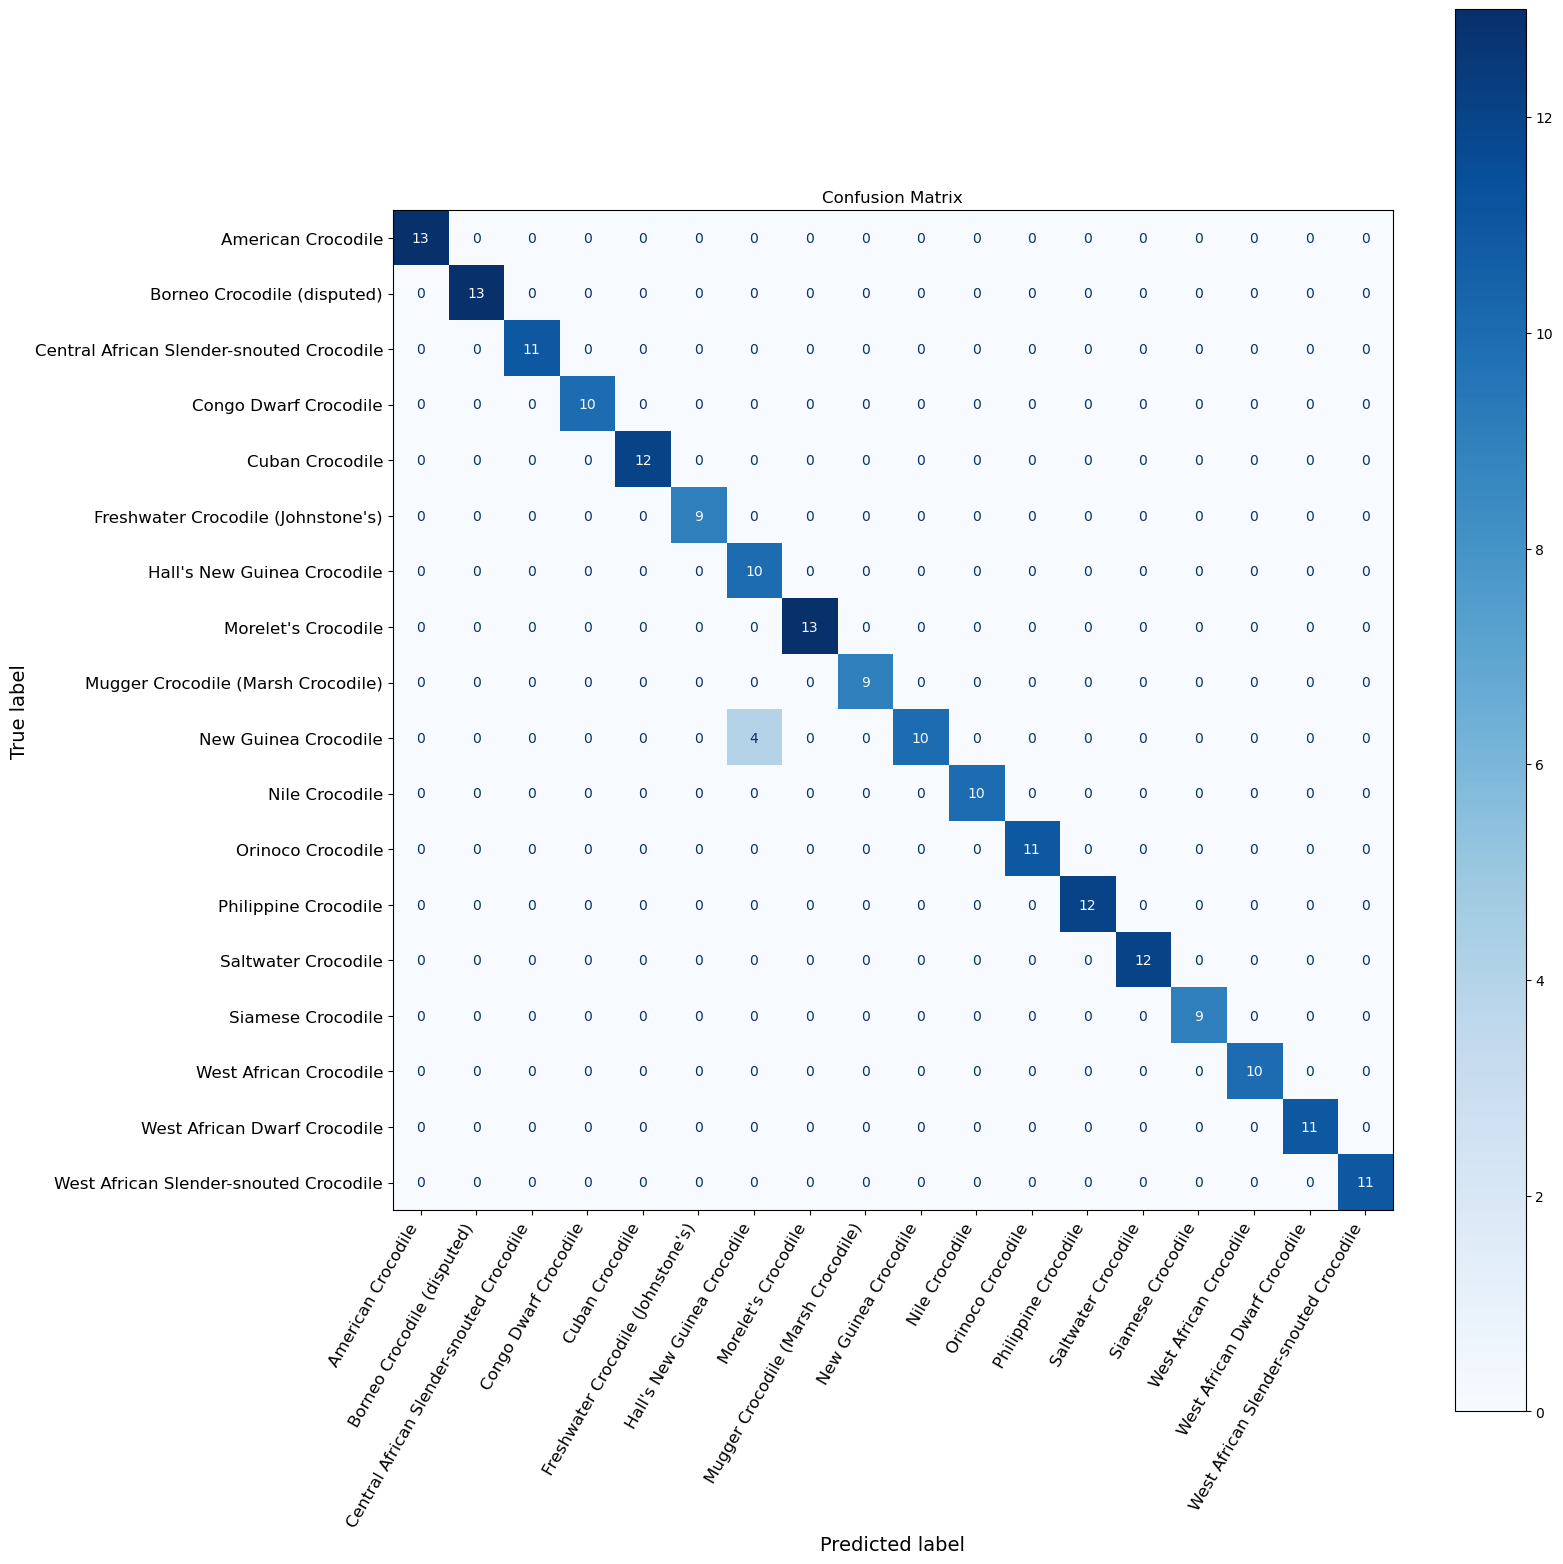

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predictions
y_pred = model_pipeline.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report (precision, recall, f1-score)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
fig, ax = plt.subplots(figsize=(16, 16))  # Make the figure even larger for more space
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_pipeline.classes_)
disp.plot(cmap="Blues", ax=ax, xticks_rotation=60)  # Rotate x labels more steeply
plt.title("Confusion Matrix")
plt.tight_layout()  # Adjust layout to fit labels
plt.xlabel("Predicted label", fontsize=14)
plt.ylabel("True label", fontsize=14)
plt.xticks(fontsize=12, ha='right')  # Align x labels to the right
plt.yticks(fontsize=12)
plt.show()

plot confusion matric sklearn

In [ ]:
correlation analysis sci kit learn
feature importncaes
cormat = con.corr()